# Pulser noise 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import scipy.signal
# from bokeh.io import show, output_file
# from bokeh.plotting import figure
# from bokeh.models import HoverTool
import time
import pandas as pd

# import tool repo
import sys

sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab1')
from tools import find_activity, import_data, subtract_baseline
from filters import fit_tau, fit_taus, JordanovFilter, BogovacFilter, CooperFilter

# sys.path.append('/Users/kalie/courses/ne204/lab/lab_partners/ne204lib')
# from kit204lib.spectrum import Spectrum
# from kit204lib.filters import jordanov_filter, cooper_filter
# from kit204lib.analyze_waveform import plot_pulses, fit_tau
# from kit204lib.make_histogram import make_histogram
from scipy.signal import find_peaks, peak_prominences

In [3]:
print('cs calibration')
f_name = '../data/2022_10_28/cs.h5'
f_data = h5py.File(f_name,'r')
cs = f_data['raw_data'][()]
cs_events = f_data['event_data'][()]
print(str(cs.shape[0])+' events')

print('co calibration')
f_name = '../data/2022_10_28/co.h5'
f_data = h5py.File(f_name,'r')
co = f_data['raw_data'][()]
co_events = f_data['event_data'][()]
print(str(co.shape[0])+' events')

print('ba calibration')
f_name = '../data/2022_10_28/ba.h5'
f_data = h5py.File(f_name,'r')
ba = f_data['raw_data'][()]
ba_events = f_data['event_data'][()]
print(str(ba.shape[0])+' events')

# pulser noise data
f_name = '../data/2022_10_28/pulser.h5'
f_data = h5py.File(f_name,'r')
noise = f_data['raw_data'][()]
noise_events = f_data['event_data'][()]
print(str(noise.shape[0])+' events')

cs calibration
152057 events
co calibration
138945 events
ba calibration
8822 events
5634 events


<IPython.core.display.Javascript object>


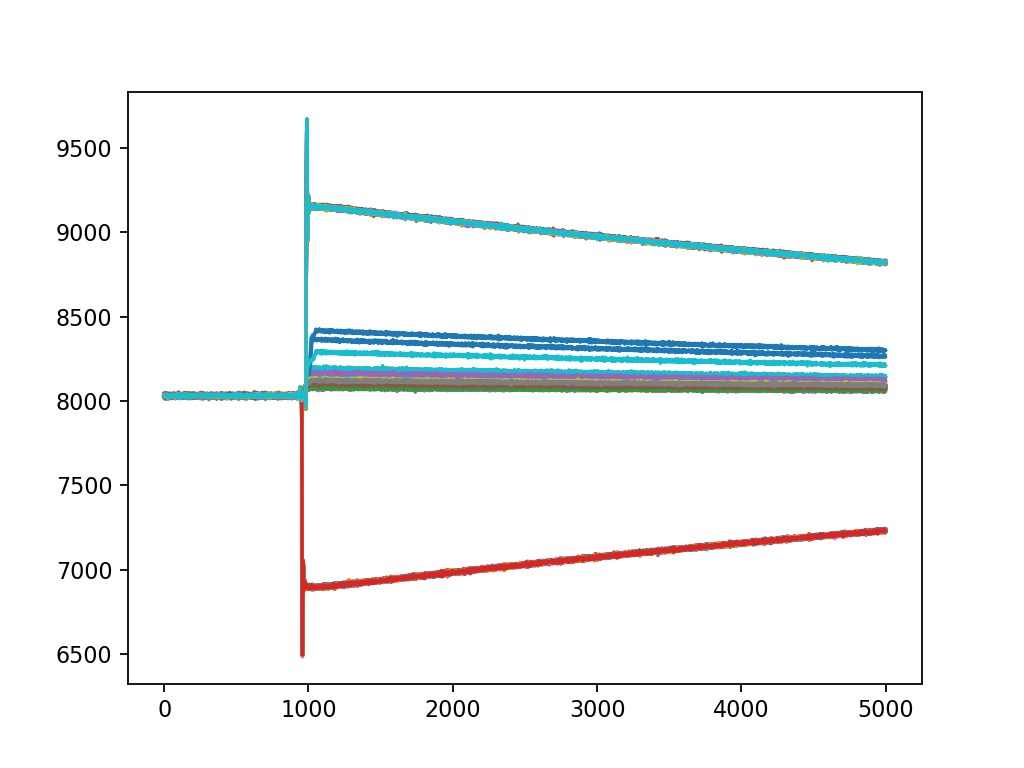

In [4]:
# plot pulser pulses
# number of random pulses
number_of_pulses = 100
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(noise))
    plt.plot(noise[n])
#plt.xlim(920,1150)
plt.show()

In [ ]:
# save as tau for filter
#tau = tau_fixed.mean()
tau = 10967.425786005182
tau = tau * 4 * 10**(-9)

peaking_time = 100 * 4 * 10**(-9)#1.6e-6/2
#peaking_time = 100 * 4 * 10**(-9) * 10
gap_time = peaking_time * 10  #6.4e-6/4

tau, peaking_time, gap_time

In [ ]:
Jordanov_filter = JordanovFilter(peaking_time, gap_time, tau)
Bogovac_filter = BogovacFilter(peaking_time, gap_time, tau)
Cooper_filter = CooperFilter(peaking_time, gap_time, tau)

In [ ]:
filtered_noise = Cooper_filter.filter_waveform(noise_bkg_down,normalize=True)

In [ ]:
plt.figure()
plt.plot(filtered_noise[2])
plt.show()